# Research - Soha Yusuf (RIN: 662011092)

# Graph Neural Network to solve Au=b

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import AddSelfLoops
from torch_geometric.data import Data, DataLoader

from scipy.sparse import coo_matrix, csr_matrix
from torch_sparse import coalesce, SparseTensor
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse.linalg import gmres

import matplotlib.pyplot as plt
import numpy as np

C:\Users\soha9\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load sparse matrix A in coo format

A:   m x n  

b:   n x 1

x:   m x 1

In [3]:
#Load the data
A_matrix_path = "data/A1_ex9.txt"
A_info = np.loadtxt(A_matrix_path)

# Extract the row, column, and value arrays from the data
row_A = A_info[:, 0].astype(int)
col_A = A_info[:, 1].astype(int)
val_A = A_info[:, 2]

# Create the sparse matrix using COO format
A = coo_matrix((val_A, (row_A, col_A)))
num_nodes = A.shape[0]

print('Number of nodes: ', num_nodes)
print('A shape: ', A.shape)

u = np.random.rand(num_nodes, 1).astype(np.float32)
b = A.dot(u).astype(np.float32)

Number of nodes:  36865
A shape:  (36865, 36865)


## GMRES

In [4]:
# Solve Ax = b using gmres and print residual error after every iteration
iteration = 0
residual_errors = []

def callback(residual):
    global iteration
    iteration += 1
    print(f'Iteration: {iteration} ==========> Residual: {np.linalg.norm(residual)}')
    residual_errors.append(residual)
    
u_gmres, info = gmres(A, b, tol=1e-13, callback=callback)

Iteration: 1 ==========> Residual: 0.24903237960419963
Iteration: 2 ==========> Residual: 0.15879892905759752
Iteration: 3 ==========> Residual: 0.060350057819426296
Iteration: 4 ==========> Residual: 0.038399424397142556
Iteration: 5 ==========> Residual: 0.02951993678431415
Iteration: 6 ==========> Residual: 0.020193598512503942
Iteration: 7 ==========> Residual: 0.01694504560305429
Iteration: 8 ==========> Residual: 0.011035538668717183
Iteration: 9 ==========> Residual: 0.008088934940194137
Iteration: 10 ==========> Residual: 0.004665636691814498
Iteration: 11 ==========> Residual: 0.003548194322686828
Iteration: 12 ==========> Residual: 0.0028355713795304334
Iteration: 13 ==========> Residual: 0.0021813208201195856
Iteration: 14 ==========> Residual: 0.0018338167936635984
Iteration: 15 ==========> Residual: 0.0014170801877749137
Iteration: 16 ==========> Residual: 0.0012418505271370502
Iteration: 17 ==========> Residual: 0.0008678712016731752
Iteration: 18 ==========> Residual: 0.

Text(0, 0.5, 'residual error')

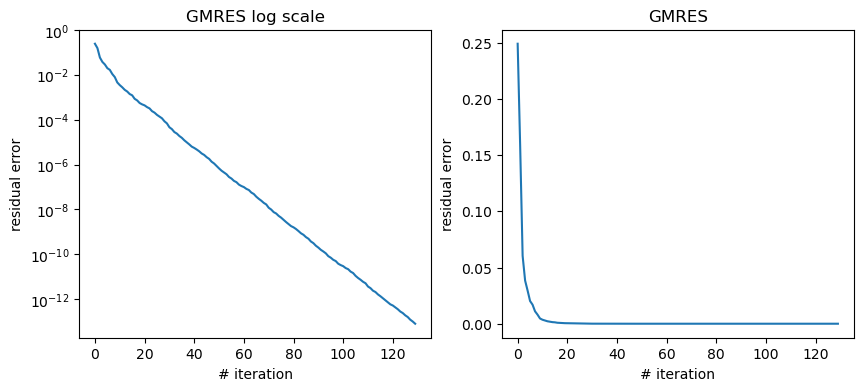

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(residual_errors)
ax1.set_title('GMRES log scale')
ax1.set_xlabel('# iteration')
ax1.set_ylabel('residual error')
ax1.set_yscale('log')

ax2.plot(residual_errors)
ax2.set_title('GMRES')
ax2.set_xlabel('# iteration')
ax2.set_ylabel('residual error')

## Convert A to pytorch tensor and normalize

In [6]:
# Convert A to PyTorch SparseTensor
indices = torch.from_numpy(np.vstack((A.row, A.col))).long()
values = torch.from_numpy(A.data).float()
shape = torch.Size(A.shape)

A = torch.sparse.FloatTensor(indices, values, shape)

print(A.shape)

torch.Size([36865, 36865])


In [7]:
# find the maximum and minimum values in A_normalized without converting to dense tensor
A_values = A.coalesce().values()
max_value = torch.max(A_values)
min_value = torch.min(A_values)

print('Min value: ', min_value.numpy())
print('Max value: ', max_value.numpy())
print('Range of A: ', (torch.abs(max_value-min_value)).numpy())

Min value:  -3.3446024e-05
Max value:  0.00022160413
Range of A:  0.00025505017


In [8]:
# compute the mean and standard deviation of the non-zero entries of A
mean = torch.mean(A.coalesce().values())
std = torch.std(A.coalesce().values())

# normalize the non-zero entries of A
A  = torch.sparse.FloatTensor(A.coalesce().indices(), (A.coalesce().values() - mean) / std, A.size())

In [9]:
# find the maximum and minimum values in A_normalized without converting to dense tensor
A_normalized_values = A.coalesce().values()
max_normalized_value = torch.max(A_normalized_values)
min_normalized_value = torch.min(A_normalized_values)

print('Min value: ', min_normalized_value.numpy())
print('Max value: ', max_normalized_value.numpy())
print('Range of A: ', (torch.abs(max_normalized_value-min_normalized_value)).numpy())

Min value:  -1.3901997
Max value:  7.588961
Range of A:  8.97916


## Compute u and b

In [10]:
# u = torch.FloatTensor(np.random.rand(num_nodes, 1))
# b = A.matmul(u)

u = torch.from_numpy(u)
b = torch.from_numpy(b)

In [11]:
A

tensor(indices=tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
                       [    1,     2,     3,  ..., 36862, 36863, 36864]]),
       values=tensor([ 0.0991, -0.0965, -0.3289,  ..., -0.3289, -0.0965,
                       0.0991]),
       size=(36865, 36865), nnz=662016, layout=torch.sparse_coo)

In [12]:
u_max = torch.max(u)
u_min = torch.min(u)

print('Min value of u: ', u_min.numpy())
print('Max value of u: ', u_max.numpy())
print('Range of u: ', (torch.abs(u_max-u_min)).numpy())

Min value of u:  5.727447e-05
Max value of u:  0.999963
Range of u:  0.9999057


In [13]:
b_max = torch.max(b)
b_min = torch.min(b)

print('Min value of u: ', b_min.numpy())
print('Max value of u: ', b_max.numpy())
print('Range of u: ', (torch.abs(b_max-b_min)).numpy())

Min value of u:  -2.9401683e-05
Max value of u:  0.00032256593
Range of u:  0.0003519676


## Edge Index

In graph neural networks, edge_index is a commonly used term that refers to a matrix or tensor that represents the edges of a graph. It is a two-dimensional matrix with two rows, where each column represents an edge of the graph. The first row of the matrix contains the index of the source nodes of each edge, while the second row contains the index of the destination nodes.

For example, let's say we have a simple undirected graph with 4 nodes and 3 edges, where the edges are (0,1), (1,2), and (2,3). We can represent this graph using the following edge_index matrix:

```
edge_index = [
  [0, 1, 1, 2],
  [1, 0, 2, 3]
]
```
Here, the first row of edge_index represents the source nodes of each edge, and the second row represents the destination nodes. For example, the first edge (0,1) has source node 0 and destination node 1.

The edge_index matrix is typically used in conjunction with node feature matrices to define the input to a graph neural network. The node feature matrix contains features for each node in the graph, while the edge_index matrix describes the edges that connect the nodes. By combining these two matrices, a graph neural network can learn to operate on the graph structure and its associated features.

## Edge Weights

In graph neural networks, edge_weights are values associated with the edges of a graph, which can be used to represent the strength, importance or similarity between connected nodes. edge_weights can be used in a variety of ways, such as during message passing, graph convolutions or pooling operations.

edge_weights can be represented as a tensor or an array, with one value per edge. If the edges are unweighted, i.e., all edges are equally important, then the edge_weights can be represented as an array of ones. However, if the edges have different weights, then the edge_weights can be assigned accordingly.

In [14]:
# Assuming A_sp is a PyTorch SparseTensor
A_coo = A.coalesce()
edge_index = A_coo.indices()
edge_weights = A_coo.values()

# Convert edge indices to PyTorch LongTensor
edge_index = edge_index.long()

In [15]:
print('====== Edge Index =====')
print('edge_index shape: ',edge_index.shape)
print(edge_index)
print('====== Edge Weights =====')
print('edge_weights shape: ',edge_weights.shape)
print(edge_weights)

====== Edge Index =====
edge_index shape:  torch.Size([2, 662016])
tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
        [    1,     2,     3,  ..., 36862, 36863, 36864]])
====== Edge Weights =====
edge_weights shape:  torch.Size([662016])
tensor([ 0.0991, -0.0965, -0.3289,  ..., -0.3289, -0.0965,  0.0991])


## Create data object for input to GNN

The Data object has the following attributes:

- **'x'**: a tensor of node features with shape **'[36865, 1]'**. This means there are 36865 nodes in the graph, each with 1 feature.
- **'edge_index'**: a tensor of shape **'[2, 662016]'** representing the edge index of the graph. The first row contains the source nodes and the second row contains the destination nodes. There are 662016 edges in the graph.

- **'edge_attr'**: a tensor of edge weights with shape **'[662016]'**. This means there is one weight for each edge in the graph.

- **'num_nodes'**: an integer value of **36865** representing the total number of nodes in the graph.

In [16]:
# Create a Data object from edge_index, edge_weights, and node features
data = Data(x=b, edge_index=edge_index, edge_attr=edge_weights, num_nodes=num_nodes, y=u)
data = data.to(device)

# Print the Data object
print(data)

Data(x=[36865, 1], edge_index=[2, 662016], edge_attr=[662016], y=[36865, 1], num_nodes=36865)


## Graph Neural Network model

The given model is a graph convolutional network (GCN) that consists of 4 graph convolutional layers.

- First layer, the model takes a feature vector of size 1 for each node and applies the GCNConv operation with 128 output channels. The output of this layer is then passed through a rectified linear unit (ReLU) activation function.

- Last layer applies the GCNConv operation with a single output channel, which is the predicted value for each node.

The model takes the input data **'x'** and **'edge_index'** and returns the predicted values for each node.

In [17]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 64)
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.conv2 = GCNConv(64, 32)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.conv3 = GCNConv(32, 16)
        self.dropout3 = torch.nn.Dropout(p=0.2)
        self.conv4 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.conv4(x, edge_index)
        return x

In [18]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(1, 64, heads=4)
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.conv2 = GATConv(64*4, 32, heads=4)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.conv3 = GATConv(32*4, 16, heads=4)
        self.dropout3 = torch.nn.Dropout(p=0.2)
        self.conv4 = GATConv(16*4, 1, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.dropout2(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.dropout3(x)
        x = self.conv4(x, edge_index)
        return x

## Train Graph Convolutional Network

In [19]:
model = GAT().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the training loop
def train(model, data, optimizer, criterion, device):
    model.train()

    # Move the data to the device
    data = data.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Compute the model output
    out = model(data.x, data.edge_index)

    # Compute the loss
    loss = criterion(out, data.y)

    # Backpropagate the gradients
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
loss_list = []
for epoch in range(500):
    loss = train(model, data, optimizer, criterion, device)
    loss_list.append(loss)
    print('Epoch {}, Loss: {}'.format(epoch, loss))

Epoch 0, Loss: 0.3347967267036438
Epoch 1, Loss: 0.32476547360420227
Epoch 2, Loss: 0.3151496648788452
Epoch 3, Loss: 0.3059280812740326
Epoch 4, Loss: 0.2970837652683258
Epoch 5, Loss: 0.2886151373386383
Epoch 6, Loss: 0.2804514169692993
Epoch 7, Loss: 0.2727220356464386
Epoch 8, Loss: 0.265196293592453
Epoch 9, Loss: 0.25808587670326233
Epoch 10, Loss: 0.2511402368545532
Epoch 11, Loss: 0.2445436418056488
Epoch 12, Loss: 0.23815207183361053
Epoch 13, Loss: 0.23208661377429962
Epoch 14, Loss: 0.22627077996730804
Epoch 15, Loss: 0.22063779830932617
Epoch 16, Loss: 0.21529200673103333
Epoch 17, Loss: 0.21016930043697357
Epoch 18, Loss: 0.20509324967861176
Epoch 19, Loss: 0.2004128247499466
Epoch 20, Loss: 0.19570595026016235
Epoch 21, Loss: 0.1913183480501175
Epoch 22, Loss: 0.1872263103723526
Epoch 23, Loss: 0.18314319849014282
Epoch 24, Loss: 0.1792474389076233
Epoch 25, Loss: 0.17551130056381226
Epoch 26, Loss: 0.17187584936618805
Epoch 27, Loss: 0.16846083104610443
Epoch 28, Loss: 0

Epoch 226, Loss: 0.08413858711719513
Epoch 227, Loss: 0.08414092659950256
Epoch 228, Loss: 0.08414514362812042
Epoch 229, Loss: 0.08418183028697968
Epoch 230, Loss: 0.08415406942367554
Epoch 231, Loss: 0.08408951014280319
Epoch 232, Loss: 0.08414295315742493
Epoch 233, Loss: 0.08405866473913193
Epoch 234, Loss: 0.08413111418485641
Epoch 235, Loss: 0.08417192846536636
Epoch 236, Loss: 0.0841331034898758
Epoch 237, Loss: 0.08411905169487
Epoch 238, Loss: 0.08415792882442474
Epoch 239, Loss: 0.08409401774406433
Epoch 240, Loss: 0.08414451777935028
Epoch 241, Loss: 0.08420570939779282
Epoch 242, Loss: 0.08419247716665268
Epoch 243, Loss: 0.08415255695581436
Epoch 244, Loss: 0.08412906527519226
Epoch 245, Loss: 0.08417452126741409
Epoch 246, Loss: 0.08412989974021912
Epoch 247, Loss: 0.08412336558103561
Epoch 248, Loss: 0.08418925851583481
Epoch 249, Loss: 0.08416500687599182
Epoch 250, Loss: 0.08410780131816864
Epoch 251, Loss: 0.0841466635465622
Epoch 252, Loss: 0.08414050936698914
Epoch 

Epoch 450, Loss: 0.08409889042377472
Epoch 451, Loss: 0.08411961048841476
Epoch 452, Loss: 0.08407801389694214
Epoch 453, Loss: 0.08407605439424515
Epoch 454, Loss: 0.08413610607385635
Epoch 455, Loss: 0.0841633677482605
Epoch 456, Loss: 0.08409179747104645
Epoch 457, Loss: 0.08414485305547714
Epoch 458, Loss: 0.08410929143428802
Epoch 459, Loss: 0.08415783196687698
Epoch 460, Loss: 0.0841497927904129
Epoch 461, Loss: 0.08412285149097443
Epoch 462, Loss: 0.08415202796459198
Epoch 463, Loss: 0.08417306840419769
Epoch 464, Loss: 0.08412566035985947
Epoch 465, Loss: 0.08412618935108185
Epoch 466, Loss: 0.08413099497556686
Epoch 467, Loss: 0.08413898944854736
Epoch 468, Loss: 0.08411753177642822
Epoch 469, Loss: 0.08416609466075897
Epoch 470, Loss: 0.08413755148649216
Epoch 471, Loss: 0.0841330885887146
Epoch 472, Loss: 0.08418061584234238
Epoch 473, Loss: 0.08409439027309418
Epoch 474, Loss: 0.08410342037677765
Epoch 475, Loss: 0.08414597809314728
Epoch 476, Loss: 0.08417429774999619
Epoc

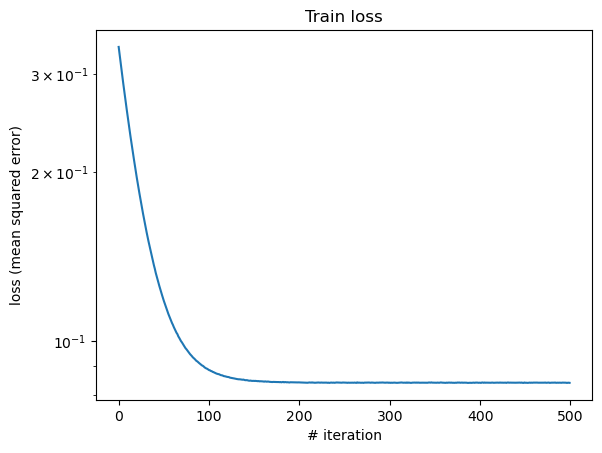

In [20]:
plt.figure(1)
plt.plot(loss_list, label = 'train loss')
plt.xlabel('# iteration')
plt.ylabel('loss (mean squared error)')
plt.yscale('log')
plt.title('Train loss')
plt.savefig('GNN_mfem_loss.png')
plt.show()

In [21]:
data.edge_index

tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
        [    1,     2,     3,  ..., 36862, 36863, 36864]], device='cuda:0')

In [22]:
# Compute predicted u and residual error
model.eval()
u_GNN = model(data.x, data.edge_index)

## Compare solutions from GMRES and GCN

In [23]:
u

tensor([[0.6785],
        [0.3946],
        [0.6953],
        ...,
        [0.9241],
        [0.3689],
        [0.6950]])

In [24]:
u_GNN

tensor([[0.4999],
        [0.4999],
        [0.4999],
        ...,
        [0.4999],
        [0.4999],
        [0.4999]], device='cuda:0', grad_fn=<AddBackward0>)

In [25]:
u_gmres.reshape(-1,1)

array([[0.        ],
       [0.39458645],
       [0.69525571],
       ...,
       [0.92412876],
       [0.36887018],
       [0.69503202]])

# Residual Error 

The residual error can be interpreted as the sum of the squared distances between the predicted values Au and the true values b. It is a measure of how well the solution u fits the original matrix equation Au = b. A lower residual error indicates a better fit of the solution to the equation.

\begin{equation}
error = \sqrt{\sum(||Au - b||^{2})}
\end{equation}

In [26]:
residual = (torch.mm(A.to(device), u_GNN) - b.to(device))
residual

tensor([[ 0.0000],
        [-1.4893],
        [-0.6405],
        ...,
        [-0.6406],
        [-0.6405],
        [-1.4893]], device='cuda:0', grad_fn=<SubBackward0>)

In [27]:
residual_error = torch.sqrt(torch.sum(torch.abs(torch.mm(A.to(device), u_GNN) - b.to(device))))
print(f'Residual error is: {residual_error}')

Residual error is: 257.71331787109375
